In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

tf.get_logger().setLevel('ERROR')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sionna

from sionna.utils import BinarySource, ebnodb2no, PlotBER
from sionna.channel import FlatFadingChannel
from sionna.mimo import lmmse_equalizer, mf_equalizer, zf_equalizer
from sionna.mapping import Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

In [3]:
sionna.config.xla_compat=True
class MIMO(tf.keras.Model):
    def __init__(self, n, k, num_bits_per_symbol, num_tx_ant, num_rx_ant, equalizer):
        super().__init__()
        # Parameters:
        self.n = n                                                     # Codeword length
        self.k = k                                                     # Size of message
        self.coderate = self.k/self.n                                  # Coderate
        self.num_bits_per_symbol = num_bits_per_symbol                 # Number of bits per symbol
        self.num_tx_ant = num_tx_ant                                   # Number of antennas in the transmitter
        self.num_rx_ant = num_rx_ant                                   # Number of antennas in the receiver
        self.equalizer = equalizer                                     # Equalizer
        #Components:
        self.binary_source = BinarySource()
        self.encoder = LDPC5GEncoder(self.k, self.n)
        self.mapper = Mapper("qam", self.num_bits_per_symbol)
        self.demapper = Demapper("app", "qam", self.num_bits_per_symbol)
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)
        self.channel = FlatFadingChannel(self.num_tx_ant,
                                         self.num_rx_ant,
                                         add_awgn=True,
                                         return_channel=True)

    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        b = self.binary_source([batch_size, self.num_tx_ant, self.k])
        c = self.encoder(b)

        x = self.mapper(c)
        shape = tf.shape(x)
        x = tf.reshape(x, [-1, self.num_tx_ant])

        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate)
        no *= np.sqrt(self.num_rx_ant)

        y, h = self.channel([x, no])
        s = tf.complex(no*tf.eye(self.num_rx_ant, self.num_rx_ant), 0.0)

        x_hat, no_eff = self.equalizer(y, h, s)

        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)

        llr = self.demapper([x_hat, no_eff])
        b_hat = self.decoder(llr)

        return b,  b_hat

In [4]:
ber_plot = PlotBER()

In [5]:
model_LMSSE = MIMO(1024, 512, 4, 2, 8, lmmse_equalizer)

ber_plot.simulate(model_LMSSE,
        np.arange(-2.5, 0.25, 0.25),
        batch_size=4096,
        max_mc_iter=8,
        num_target_block_errors=100,
        legend="LMMSE",
        show_fig=False)


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -2.5 | 2.1000e-01 | 1.0000e+00 |      880819 |     4194304 |         8192 |        8192 |        16.2 |reached target block errors
    -2.25 | 1.9912e-01 | 1.0000e+00 |      835149 |     4194304 |         8192 |        8192 |        11.1 |reached target block errors
     -2.0 | 1.8612e-01 | 9.9976e-01 |      780645 |     4194304 |         8190 |        8192 |        10.4 |reached target block errors
    -1.75 | 1.7174e-01 | 9.9866e-01 |      720335 |     4194304 |         8181 |        8192 |        10.8 |reached target block errors
     -1.5 | 1.5099e-01 | 9.8999e-01 |      633290 |     4194304 |         8110 |        8192 |        10.7 |reached target block errors
    -1.25 | 1.2813e-01 | 9.5923e-01 |      537401 |     4194304 |

(<tf.Tensor: shape=(11,), dtype=float64, numpy=
 array([0.21000361, 0.19911504, 0.18612027, 0.17174125, 0.1509881 ,
        0.12812638, 0.09867954, 0.06669116, 0.0396347 , 0.01935768,
        0.00788355])>,
 <tf.Tensor: shape=(11,), dtype=float64, numpy=
 array([1.        , 1.        , 0.99975586, 0.99865723, 0.98999023,
        0.95922852, 0.87036133, 0.70654297, 0.49829102, 0.28710938,
        0.13037109])>)

In [6]:
model_ZFE = MIMO(1024, 512, 4, 2, 8, zf_equalizer)

ber_plot.simulate(model_ZFE,
        np.arange(-2.5, 0.25, 0.25),
        batch_size=4096,
        max_mc_iter=1000,
        num_target_block_errors=100,
        legend="ZF",
        show_fig=False)


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -2.5 | 2.1647e-01 | 1.0000e+00 |      907931 |     4194304 |         8192 |        8192 |        13.0 |reached target block errors
    -2.25 | 2.0597e-01 | 1.0000e+00 |      863914 |     4194304 |         8192 |        8192 |        10.4 |reached target block errors
     -2.0 | 1.9456e-01 | 9.9988e-01 |      816038 |     4194304 |         8191 |        8192 |        11.3 |reached target block errors
    -1.75 | 1.8037e-01 | 9.9988e-01 |      756541 |     4194304 |         8191 |        8192 |        12.4 |reached target block errors
     -1.5 | 1.6437e-01 | 9.9731e-01 |      689407 |     4194304 |         8170 |        8192 |        11.5 |reached target block errors
    -1.25 | 1.4324e-01 | 9.8071e-01 |      600786 |     4194304 |

(<tf.Tensor: shape=(11,), dtype=float64, numpy=
 array([0.21646762, 0.20597315, 0.19455862, 0.18037343, 0.16436744,
        0.14323854, 0.11512184, 0.08348703, 0.05184078, 0.02911234,
        0.01229358])>,
 <tf.Tensor: shape=(11,), dtype=float64, numpy=
 array([1.        , 1.        , 0.99987793, 0.99987793, 0.99731445,
        0.98071289, 0.92773438, 0.80432129, 0.59887695, 0.38806152,
        0.19567871])>)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -2.5 | 2.4223e-01 | 1.0000e+00 |     1016004 |     4194304 |         8192 |        8192 |        15.2 |reached target block errors
    -2.25 | 2.3612e-01 | 1.0000e+00 |      990367 |     4194304 |         8192 |        8192 |        10.3 |reached target block errors
     -2.0 | 2.2975e-01 | 1.0000e+00 |      963621 |     4194304 |         8192 |        8192 |        10.1 |reached target block errors
    -1.75 | 2.2365e-01 | 1.0000e+00 |      938039 |     4194304 |         8192 |        8192 |        10.1 |reached target block errors
     -1.5 | 2.1714e-01 | 1.0000e+00 |      910760 |     4194304 |         8192 |        8192 |        10.1 |reached target block errors
    -1.25 | 2.0984e-01 | 1.0000e+00 |      880120 |     4194304 |

(<tf.Tensor: shape=(11,), dtype=float64, numpy=
 array([0.24223423, 0.23612189, 0.22974515, 0.22364593, 0.21714211,
        0.20983696, 0.20195436, 0.19368052, 0.18453622, 0.17388487,
        0.16146851])>,
 <tf.Tensor: shape=(11,), dtype=float64, numpy=
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.99975586, 0.99865723,
        0.99560547])>)

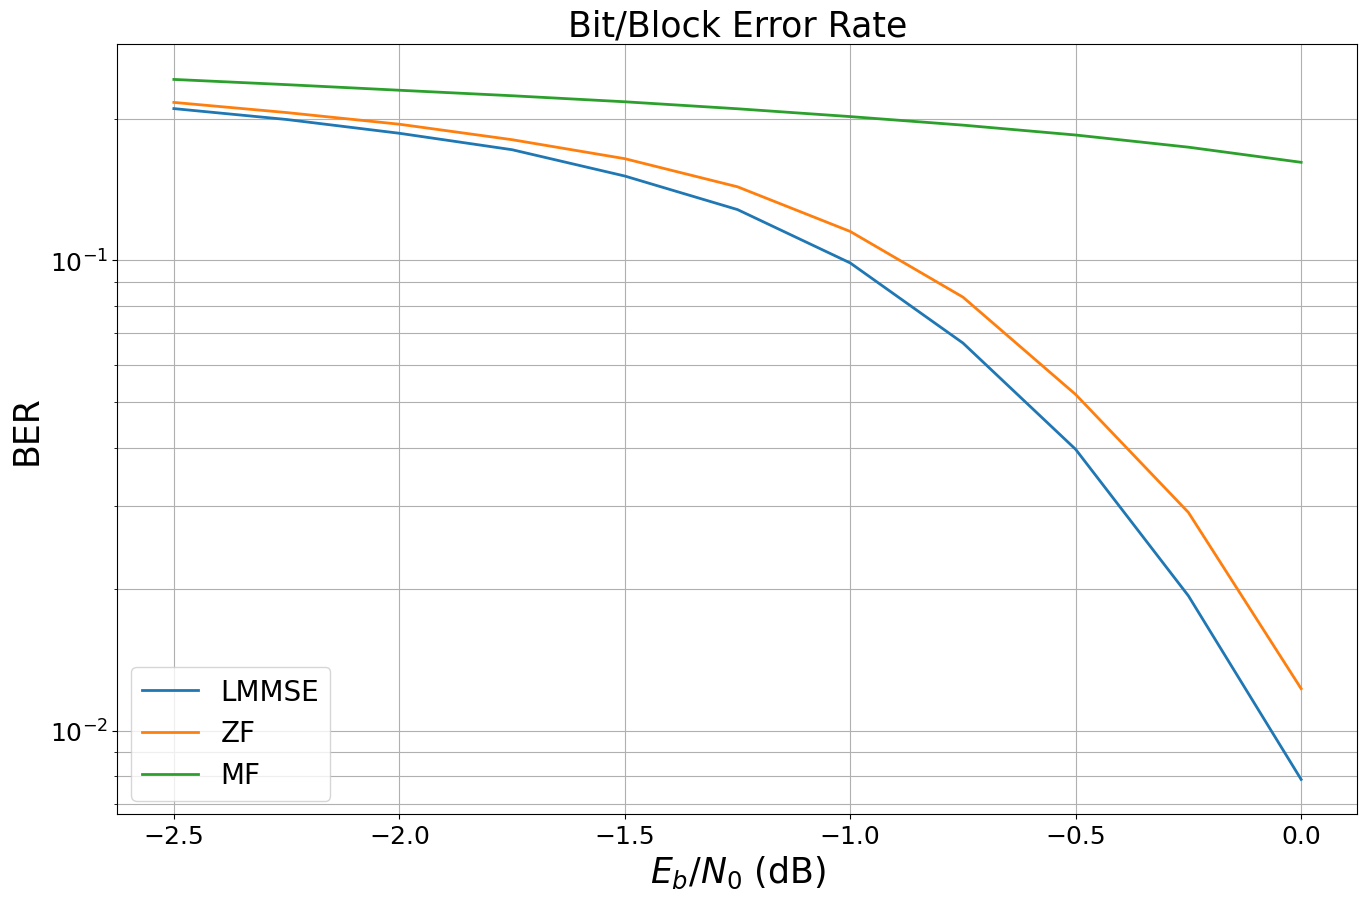

In [7]:
model_MF = MIMO(1024, 512, 4, 2, 8, mf_equalizer)

ber_plot.simulate(model_MF,
        np.arange(-2.5, 0.25, 0.25),
        batch_size=4096,
        max_mc_iter=1000,
        num_target_block_errors=200,
        legend="MF")
